# Import Data

In [35]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Read Data
data = pd.read_csv('Data/tblADataRTCGM_Unblinded_RTCGMGroup_1.csv')

# Convert Data
data['DeviceDtTm'] = pd.to_datetime(data['DeviceDtTm'])
#data = data.groupby('PtID').apply(lambda x: x.sort_values('DeviceDtTm'))
data = data.sort_values(['PtID', 'DeviceDtTm'])


# Normalize Data (Glucose)
scaler = MinMaxScaler(feature_range=(0, 1))
data['Glucose'] = scaler.fit_transform(data['Glucose'].values.reshape(-1, 1))

unique_pt_ids = data['PtID'].unique()
print(unique_pt_ids)

[  1  10  11  14 102 103 104 107 114 115 116 119 120 127 128 130 134 137
 143 144]


In [36]:
# Search for null values
missing_values = data.isnull().sum()
print(missing_values)

RecID         0
PtID          0
DeviceDtTm    0
Glucose       0
dtype: int64


In [37]:
# Search Data for Specific PtID
data_patient_2 = data.loc[data['PtID'] == 10]
data_patient_2

,RecID,PtID,DeviceDtTm,Glucose
18081,5675215,10,2000-11-04 09:32:20,0.255486
18082,5675216,10,2000-11-04 09:42:21,0.258621
18967,5676101,10,2000-11-04 09:52:26,0.266458
18968,5676102,10,2000-11-04 10:02:27,0.275862
18969,5676103,10,2000-11-04 10:12:23,0.275862
...,...,...,...,...
48140,17640612,10,2001-10-31 10:50:26,0.473354
48141,17640613,10,2001-10-31 11:00:29,0.473354
48142,17640614,10,2001-10-31 11:10:27,0.454545
48143,17640615,10,2001-10-31 11:20:27,0.407524


In [38]:
grouped = data.groupby('PtID')

sequences = []
targets = []

sequence_length = 5

# Generate sequences for each patient
for name, group in grouped:
    # Prepare sequences for each PtID
    glucose_values = group['Glucose'].values
    for i in range(sequence_length, len(glucose_values)):
        sequences.append(glucose_values[i-sequence_length:i])
        targets.append(glucose_values[i])

sequences = np.array(sequences)
targets = np.array(targets)

# Reshape for LSTM input
sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], 1))


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


model.fit(sequences, targets, epochs=10, verbose=1)


Epoch 1/10
31275/31275 [==============================] - 143s 4ms/step - loss: 2.5720e-04
Epoch 2/10
31275/31275 [==============================] - 137s 4ms/step - loss: 1.8639e-04
Epoch 3/10
31275/31275 [==============================] - 64s 2ms/step - loss: 1.8385e-04
Epoch 4/10
31275/31275 [==============================] - 59s 2ms/step - loss: 1.8279e-04
Epoch 5/10
31275/31275 [==============================] - 66s 2ms/step - loss: 1.8207e-04
Epoch 6/10
31275/31275 [==============================] - 68s 2ms/step - loss: 1.8174e-04
Epoch 7/10
31275/31275 [==============================] - 69s 2ms/step - loss: 1.8124e-04
Epoch 8/10
31275/31275 [==============================] - 64s 2ms/step - loss: 1.8113e-04
Epoch 9/10
31275/31275 [==============================] - 66s 2ms/step - loss: 1.8109e-04
Epoch 10/10
31275/31275 [==============================] - 68s 2ms/step - loss: 1.8090e-04


In [69]:
data = pd.read_csv('Data/tblADataRTCGM_Unblinded_RTCGMGroup_2.csv')

# Convert Data
data['DeviceDtTm'] = pd.to_datetime(data['DeviceDtTm'])
#data = data.groupby('PtID').apply(lambda x: x.sort_values('DeviceDtTm'))
data = data.sort_values(['PtID', 'DeviceDtTm'])


# Normalize Data (Glucose)
scaler = MinMaxScaler(feature_range=(0, 1))
data['Glucose'] = scaler.fit_transform(data['Glucose'].values.reshape(-1, 1))

unique_pt_ids = data['PtID'].unique()
print(unique_pt_ids)

[ 16 152 153 154 156 157 158 161 163 165 167 168 169 177 181 183 185 186]


1461/1461 [==============================] - 1s 999us/step


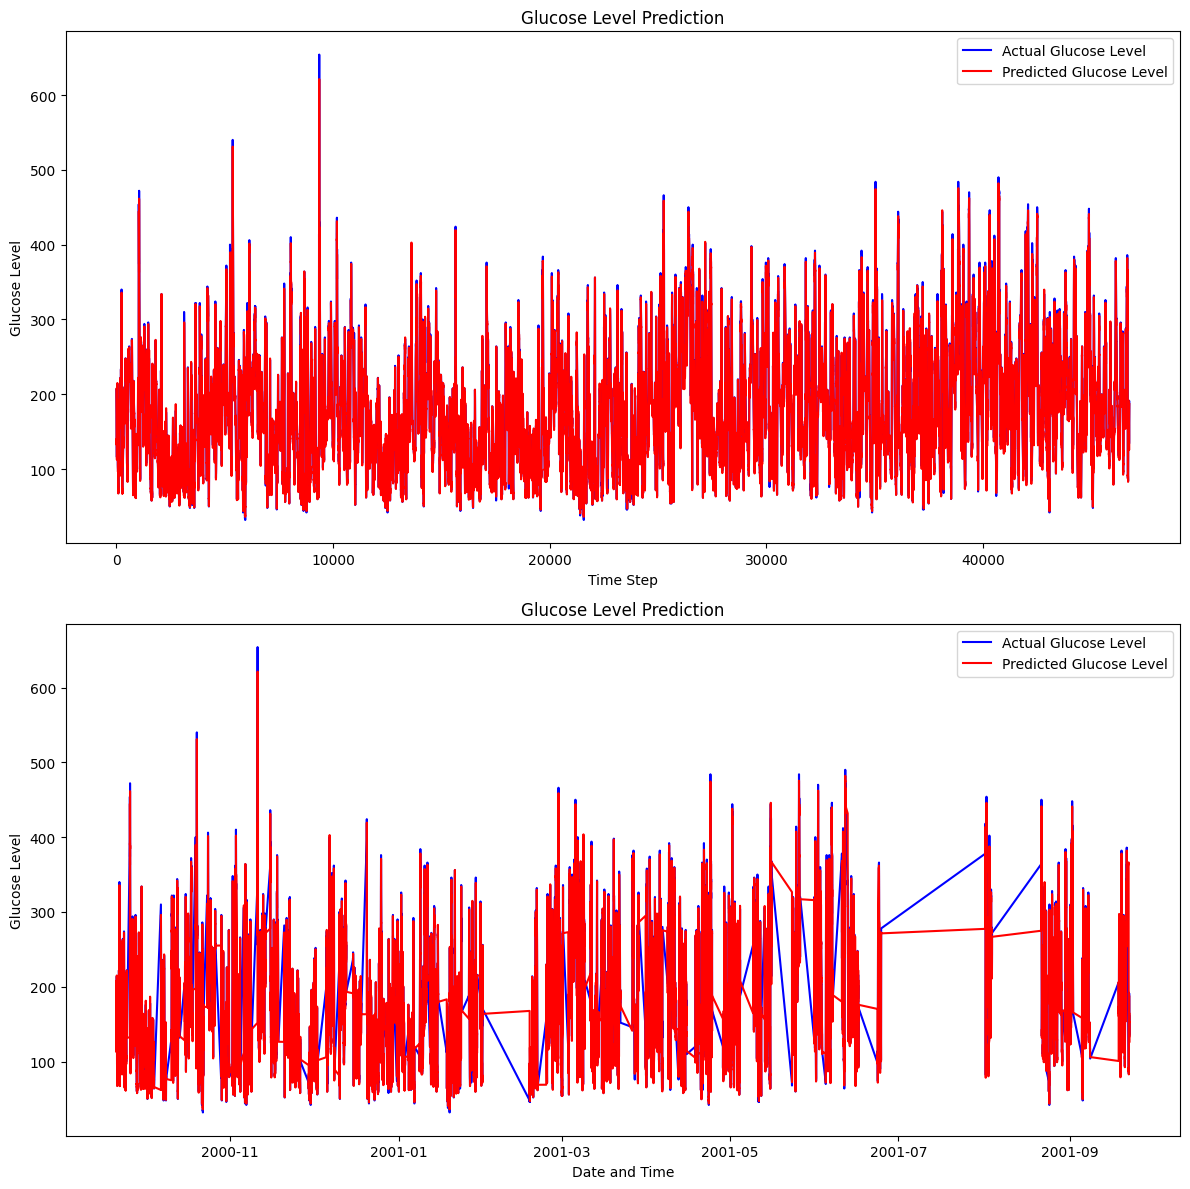

In [70]:
import matplotlib.pyplot as plt

patient_id = 152

patient_data = data[data['PtID'] == patient_id].sort_values('DeviceDtTm')

glucose_values = patient_data['Glucose'].values
patient_sequences = []
for i in range(sequence_length, len(glucose_values)):
    patient_sequences.append(glucose_values[i-sequence_length:i])

patient_sequences = np.array(patient_sequences)
patient_sequences = np.reshape(patient_sequences, (patient_sequences.shape[0], patient_sequences.shape[1], 1))
predictions = model.predict(patient_sequences)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
actual_values = scaler.inverse_transform(glucose_values[sequence_length:].reshape(-1, 1))


fig, axs = plt.subplots(2, figsize=(12,12))

axs[0].plot(range(sequence_length, len(glucose_values)), actual_values, color='blue', label='Actual Glucose Level')
axs[0].plot(range(sequence_length, len(glucose_values)), predictions, color='red', label='Predicted Glucose Level')
axs[0].set_title('Glucose Level Prediction')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Glucose Level')
axs[0].legend()

patient_data['DeviceDtTm'] = pd.to_datetime(patient_data['DeviceDtTm'])
time_values = patient_data['DeviceDtTm'].values[sequence_length:]
axs[1].plot(time_values, actual_values, color='blue', label='Actual Glucose Level')
axs[1].plot(time_values, predictions, color='red', label='Predicted Glucose Level')
axs[1].set_title('Glucose Level Prediction')
axs[1].set_xlabel('Date and Time')
axs[1].set_ylabel('Glucose Level')
axs[1].legend()

plt.tight_layout()
plt.show()

159/159 [==============================] - 0s 1ms/step


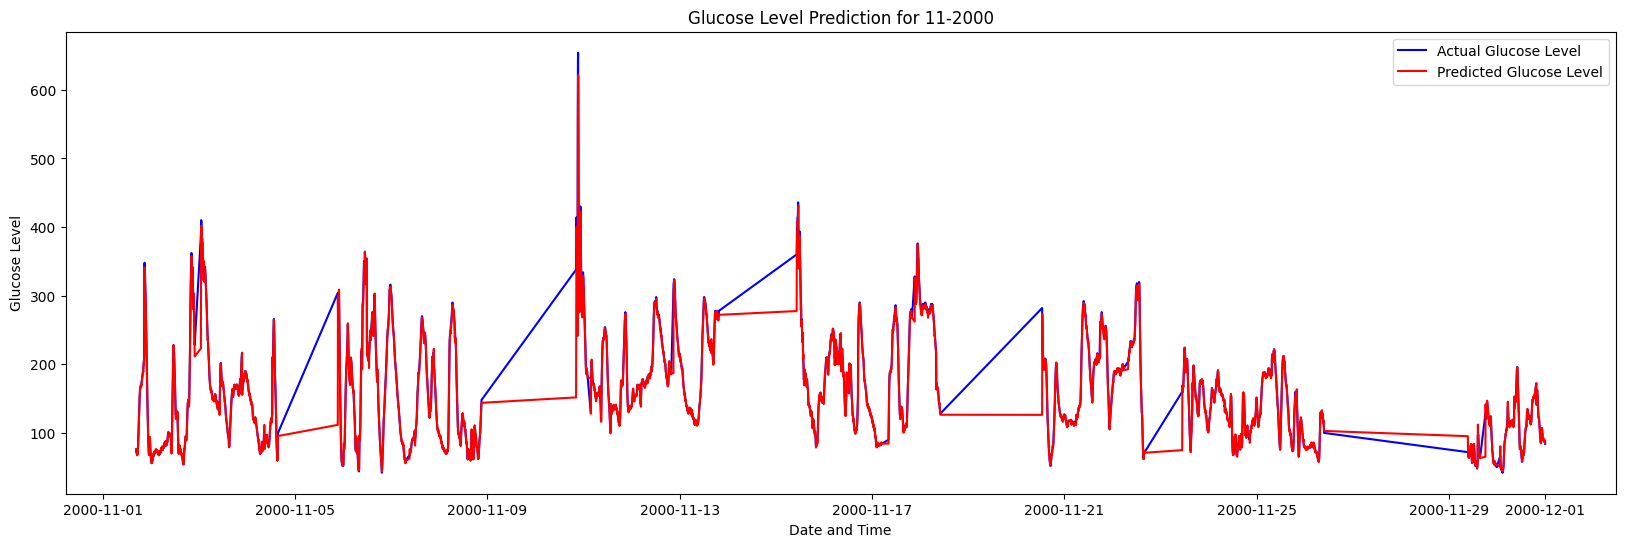

In [77]:

year = 2000
month = 11
start_day = 1
end_day = 30

patient_data_filtered = patient_data[(patient_data['DeviceDtTm'].dt.year == year)
                                    & (patient_data['DeviceDtTm'].dt.month == month)
                                    & (patient_data['DeviceDtTm'].dt.day >= start_day)
                                    & (patient_data['DeviceDtTm'].dt.day <= end_day)]

time_values_filtered = patient_data_filtered['DeviceDtTm'].values
glucose_values_filtered = patient_data_filtered['Glucose'].values
filtered_sequences = [glucose_values_filtered[i-sequence_length:i].reshape(-1, 1) for i in range(sequence_length, len(glucose_values_filtered))]

filtered_sequences = np.array(filtered_sequences)
filtered_sequences = np.reshape(filtered_sequences, (filtered_sequences.shape[0], filtered_sequences.shape[1], 1))
predictions_filtered = model.predict(filtered_sequences)

actual_values_filtered = scaler.inverse_transform(glucose_values_filtered[sequence_length:].reshape(-1, 1))
predictions_filtered = scaler.inverse_transform(predictions_filtered.reshape(-1, 1))

plt.figure(figsize=(20,6))
plt.plot(time_values_filtered[sequence_length:], actual_values_filtered, color='blue', label='Actual Glucose Level')
plt.plot(time_values_filtered[sequence_length:], predictions_filtered, color='red', label='Predicted Glucose Level')
plt.title('Glucose Level Prediction for {}-{}'.format(month, year))
plt.xlabel('Date and Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()
